In [3]:
%matplotlib inline

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Set, Any

from utils import data, text, visualization

In [4]:
train_texts, train_data = data.load_dataset(preprocess=True)
test_texts = data.load_texts('test', preprocess=True)

100%|██████████| 5/5 [00:00<00:00, 5000.36it/s]


In [3]:
train_data

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1618153340639,2234,3203,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...
144289,4C471936CD75,1618153383399,3221,4509,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...
144290,4C471936CD75,1618024996127,4510,4570,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838
144291,4C471936CD75,1618025268756,4570,4922,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...


In [5]:
END_OF_SENTENCES = re.compile('[.,;!?]')
END_OF_SENTENCES = re.compile('[.,;!?]')
dataset_complete = pd.DataFrame({'id':train_texts.index, 'text':train_texts.values})
dataset_complete['sentences'] = dataset_complete['text'].apply(lambda x: END_OF_SENTENCES.split(x))

def compute_positions(sentences):
    ret = []
    initial = 0
    for s in sentences:
        end = initial + len(s)
        ret.append((initial, end))
        initial = end + 1
    return ret

dataset_complete['positions'] = dataset_complete['sentences'].apply(compute_positions)

THRESHOLD = 0.5
def is_intersected(s1: Set[Any], s2: Set[Any]):
    if len(s1) == 0 or len(s2) == 0:
        return False
    intersection = len(s1.intersection(s2)) 
    return intersection / len(s1) > THRESHOLD or intersection / len(s2) > THRESHOLD

gb = train_data.groupby(by='id')

def retrieve_labels(text_id, positions):
    tags = gb.get_group(text_id)
    labels = []
    for ps, pe in positions:
        label = 'NO LABEL'
        pos = set(range(ps, pe))
        for ds, de, l in zip(tags['discourse_start'], tags['discourse_end'], tags['discourse_type']):
            dis = set(range(ds, de))
            if is_intersected(pos, dis):
                label = l
                break
        labels.append(label)
    return labels


dataset_complete['labels'] = dataset_complete.apply(lambda s: retrieve_labels(s['id'], s['positions']), axis=1)

In [6]:
dataset_complete

,id,text,sentences,positions,labels
0,0000D23A521A,some people belive that the so called face on ...,[some people belive that the so called face on...,"[(0, 78), (79, 100), (101, 166), (167, 196), (...","[Position, Position, Position, Evidence, Evide..."
1,00066EA9880D,driverless cars are exaclty what you would exp...,[driverless cars are exaclty what you would ex...,"[(0, 60), (61, 164), (165, 285), (286, 371), (...","[Lead, Lead, Lead, Lead, Lead, Position, Claim..."
2,000E6DE9E817,dear principali am arguing against the policy ...,[dear principali am arguing against the policy...,"[(0, 154), (155, 303), (304, 416), (417, 462),...","[Position, Rebuttal, Evidence, Claim, Claim, E..."
3,001552828BD0,would you be able to give your car up? having ...,"[would you be able to give your car up, havin...","[(0, 37), (38, 99), (100, 158), (159, 224), (2...","[Lead, Lead, Lead, Evidence, Evidence, Evidenc..."
4,0016926B079C,i think that students would benefit from learn...,[i think that students would benefit from lear...,"[(0, 57), (58, 149), (150, 233), (234, 267), (...","[Position, Claim, Claim, Claim, Evidence, Evid..."
...,...,...,...,...,...
15589,FFF1442D6698,"every student looks forward to summer break, i...","[every student looks forward to summer break, ...","[(0, 43), (44, 89), (90, 108), (109, 170), (17...","[Lead, Lead, Lead, Lead, Lead, Lead, Lead, Lea..."
15590,FFF1ED4F8544,many citizens argue that the electoral college...,[many citizens argue that the electoral colleg...,"[(0, 56), (57, 217), (218, 240), (241, 278), (...","[Lead, Lead, Lead, Lead, Lead, Position, Claim..."
15591,FFF868E06176,"every summer break, students are given project...","[every summer break, students are given proje...","[(0, 18), (19, 119), (120, 193), (194, 221), (...","[Lead, Lead, Lead, Lead, Position, NO LABEL, C..."
15592,FFFD0AF13501,in the article a cowboy who rode the waves luk...,[in the article a cowboy who rode the waves lu...,"[(0, 175), (176, 274), (275, 341), (342, 424),...","[NO LABEL, Claim, Claim, Evidence, Claim, Clai..."


In [7]:
example_id = dataset_complete['id'][15591]

In [12]:
visualization.highlight_segments(example_id, train_data, texts=train_texts)

NameError: name 'example_id' is not defined

In [9]:
visualization.highlight_segments(example_id, dataset_complete)

In [13]:
train_data.groupby(by='id').count()['discourse_id'].describe()

count    15594.000000
mean         9.253110
std          3.124329
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         26.000000
Name: discourse_id, dtype: float64

<AxesSubplot:>

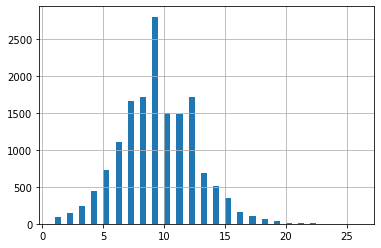

In [12]:
train_data.groupby(by='id').count()['discourse_id'].hist(bins=50)